In [6]:
#####Nested Directed Graph Embedding model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [7]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [9]:
####データの生成####
##データの設定
k1 = 10
k2 = 10
factor1 = 5000
factor2 = 3000
Lambda = np.random.gamma(20.0, 1/0.2, factor1)
pt = np.random.poisson(Lambda, factor1)
N = np.sum(pt)

In [10]:
##IDとインデックスの作成
#IDの作成
d_id1 = np.repeat(np.arange(factor1), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt1[i]), dtype="int") for i in range(factor1)])))

#インデックスの作成
d_list1 = [i for i in range(factor1)]
for i in range(factor1):
    d_list1[i] = np.array(np.where(d_id1==i)[0], dtype="int")

In [11]:
##factorの割当を生成
#トピック割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, factor2), topic)
theta = np.random.dirichlet(np.repeat(0.5, topic), factor1)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(factor1)]).reshape(factor1, topic), range(topic))

#多項分布からアイテムを生成
d_id2 = np.zeros(N, dtype='int')
for i in range(factor1):
    if i%1000==0:
        print(i)
    d_id2[d_list1[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(factor2))
    
#インデックスの作成
d_list2 = [i for i in range(factor2)]
pt2 = np.repeat(0, factor2)
for i in range(factor2):
    d_list2[i] = np.array(np.where(d_id2==i)[0], dtype="int")
    pt2[i] = d_list2[i].shape[0]

0
1000
2000
3000
4000


In [12]:
####応答変数の生成####
per_min = 100; per_max = 100
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータの生成
    #階層モデルの事前分布のパラメータ
    alpha1 = np.repeat(0.0, k1)
    alpha21 = np.repeat(1.0, k2)
    alpha22 = np.repeat(0.0, k2)
    Cov_v1 = np.diag(np.repeat(0.3, k1))
    Cov_v2 = np.diag(np.repeat(0.3, k1))
    tau1 = np.array([0.5])
    tau2 = np.array([0.5])
    Covt_v1 = Cov_v1.copy(); Covt_v2 = Cov_v2.copy()
    taut1 = tau1.copy(); taut2 = tau2.copy()
    
    #モデルパラメータを生成
    beta = np.array([-1.0])
    theta_v11 = np.random.multivariate_normal(alpha1, Cov_v1, factor1)
    theta_v12 = np.random.multivariate_normal(alpha1, Cov_v1, factor1)
    theta_v21 = np.random.multivariate_normal(alpha21, Cov_v2, factor2)
    theta_v22 = np.random.multivariate_normal(alpha22, Cov_v2, factor2)
    omega1 = np.random.normal(0, tau1, k1*k2).reshape(k1, k2)
    omega2 = np.random.normal(0, tau2, k1*k2).reshape(k1, k2)
    Sigma = np.array([1.0])
    betat = beta.copy()
    thetat_v11 = theta_v11.copy(); thetat_v12 = theta_v12.copy()
    thetat_v21 = theta_v21.copy(); thetat_v22 = theta_v22.copy()
    omegat1 = omega1.copy(); omegat2 = omega2.copy()

    ##正規分布から潜在変数を生成
    #モデルの期待値
    nested_uv = np.dot(theta_v11, omega1)[d_id1, ] * theta_v21[d_id2, ]
    uv1 = np.sum(np.dot(nested_uv, omega2) * theta_v12[d_id1, ], axis=1)
    uv2 = np.sum(np.dot(nested_uv, omega2) * theta_v22[d_id2, ], axis=1)
    mu1 = beta + uv1; mu2 = beta + uv2

    #潜在変数の生成と二値変数への変換
    U1 = np.random.normal(mu1, Sigma, N)
    U2 = np.random.normal(mu2, Sigma, N)
    y1 = (U1 >= 0)*1 + (U1 < 0)*0; y2 = (U2 >= 0)*1 + (U2 < 0)*0
    Prob1 = norm.cdf(mu1, 0, Sigma); Prob2 = norm.cdf(mu2, 0, Sigma)

    #break条件
    if ((np.mean(y1) > 0.2) & (np.mean(y1) < 0.4) & (np.mean(y2) > 0.2) & (np.mean(y2) < 0.4) &
        (np.sum(U1 <= -7.5) < N/per_min) & (np.sum(U1 > 7.5) < N/per_max) & 
        (np.sum(U2 <= -7.5) < N/per_min) & (np.sum(U2 > 7.5) < N/per_max)):
            break

1
2
3
4
5
6
7


In [13]:
#応答変数をリストに格納
mu = [mu1, mu2]
U = [U1, U2]
y = [y1, y2]
Prob = [Prob1, Prob2]

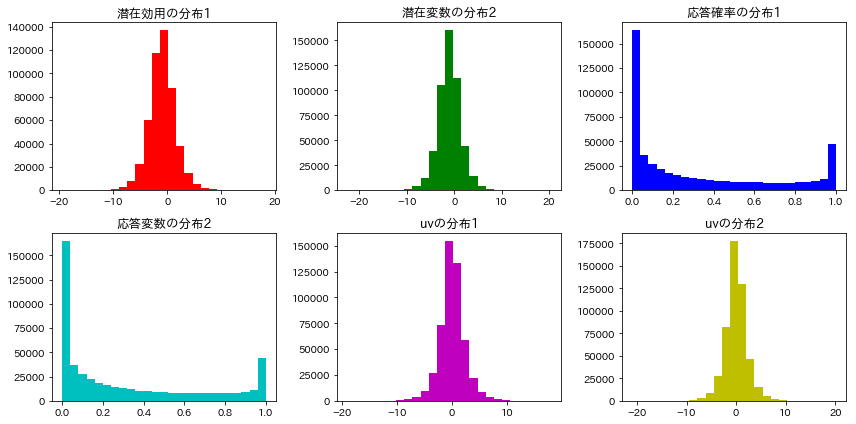

In [14]:
#潜在変数ごとのヒストグラム
dt = [U1, U2, Prob1, Prob2, uv1, uv2]
fig_range = np.append(np.array([np.min(U1), np.min(U2), 0, 0, np.min(uv1), np.min(uv2)]), 
                      np.array([np.max(U1), np.max(U2), 1.0, 1.0, np.max(uv1), np.max(uv2)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["潜在効用の分布1", "潜在変数の分布2", "応答確率の分布1", "応答変数の分布2", "uvの分布1", "uvの分布2"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [15]:
####Nested Directed Graph Embedding modelを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [16]:
##アルゴリズムの設定
k = 10
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
target_iter = 50

In [17]:
##データの設定
#切断領域を定義
type_n = 2
rho = 100.0
y = np.append(y1, y2)
a1 = np.array((1-y1)*(-rho) + y1*0)
b1 = np.array(y1*rho + (1-y1)*0)
a2 = np.array((1-y2)*(-rho) + y2*0)
b2 = np.array(y2*rho + (1-y2)*0)

#特徴行列の割当インデックス
allocation1 = np.repeat(np.arange(k2), k2)
allocation2 = np.tile(np.arange(k2), k2)
allocation_u = np.repeat(np.arange(k1), k2)
allocation_v = np.tile(np.arange(k2), k1)

In [18]:
##事前分布の設定
#階層モデルの事前分布
alpha1 = np.repeat(0.0, k1)
alpha21 = np.repeat(1.0, k2)
alpha22 = np.repeat(0.0, k2)
V1 = 0.1 * np.diag(np.ones(k1))
V2 = 0.1 * np.diag(np.ones(k2))
nu = 1.0

#モデルパラメータの事前分布
tau = 100 
s02 = 1.0
v02 = 1.0

In [19]:
##パラメータの真値
#階層モデルのパラメータの真値
Cov_v11 = Covt_v1.copy(); inv_Cov_v11 = np.linalg.inv(Cov_v11)
Cov_v12 = Covt_v1.copy(); inv_Cov_v12 = np.linalg.inv(Cov_v12)
Cov_v21 = Covt_v2.copy(); inv_Cov_v21 = np.linalg.inv(Cov_v21)
Cov_v22 = Covt_v1.copy(); inv_Cov_v22 = np.linalg.inv(Cov_v22)
tau1 = taut1.copy()
tau2 = taut2.copy()

#モデルパラメータの真値
Sigma = np.array([1.0])
beta = betat.copy()
theta_v11 = thetat_v11.copy()
theta_v12 = thetat_v12.copy()
theta_v21 = thetat_v21.copy()
theta_v22 = thetat_v22.copy()
omega1 = omegat1.copy()
omega2 = omegat2.copy()

#モデルの期待値
nested_uv = np.dot(theta_v11, omega1)[d_id1, ] * theta_v21[d_id2, ]
uv1 = np.sum(np.dot(nested_uv, omega2) * theta_v12[d_id1, ], axis=1)
uv2 = np.sum(np.dot(nested_uv, omega2) * theta_v22[d_id2, ], axis=1)
mu1 = beta + uv1; mu2 = beta + uv2

In [20]:
##パラメータの格納用配列
#階層モデルの格納用配列
COV_V11 = np.zeros((k1, k1, int(R/keep)))
COV_V12 = np.zeros((k1, k1, int(R/keep)))
COV_V21 = np.zeros((k2, k2, int(R/keep)))
COV_V22 = np.zeros((k2, k2, int(R/keep)))

#モデルパラメータの格納用配列
BETA = np.repeat(0.0, int(R/keep))
THETA_V11 = np.zeros((factor1, k1, int(R/keep)))
THETA_V12 = np.zeros((factor1, k1, int(R/keep)))
THETA_V21 = np.zeros((factor2, k1, int(R/keep)))
THETA_V22 = np.zeros((factor2, k1, int(R/keep)))
OMEGA1 = np.zeros((k1, k2, int(R/keep)))
OMEGA2 = np.zeros((k1, k2, int(R/keep)))

In [21]:
####ギブスサンプリングでパラメータをサンプリング####
##切断正規分布から潜在効用を生成
#モデルの期待値
nested_uv = np.dot(theta_v11, omega1)[d_id1, ] * theta_v21[d_id2, ]
uv1 = np.sum(np.dot(nested_uv, omega2) * theta_v12[d_id1, ], axis=1)
uv2 = np.sum(np.dot(nested_uv, omega2) * theta_v22[d_id2, ], axis=1)
mu1 = beta + uv1; mu2 = beta + uv2
uv = np.append(uv1, uv2); mu = np.append(mu1, mu2)

#潜在変数を生成
U1 = np.array(rtnorm(mu1, Sigma, a1, b1, N))
U2 = np.array(rtnorm(mu2, Sigma, a2, b2, N))
U = np.append(U1, U2)

In [22]:
##モデルパラメータのサンプリング
#モデル誤差を定義
er_y = U - uv

#正規分布から事後分布をサンプリング
weights = tau / (Sigma/(2*N) + tau)
mu_par = weights * np.mean(er_y)
beta = np.random.normal(mu_par, weights*Sigma/(2*N), 1)